In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pydaptivefiltering as pdf

In [2]:
def generate_qam_signal(n_samples, order=16):
    """Gera sinais QAM normalizados para módulo constante médio."""
    side = int(np.sqrt(order))
    bits = np.random.randint(0, order, n_samples)
    mapping = np.arange(side) - (side - 1) / 2
    x, y = np.meshgrid(mapping, mapping)
    constellation = (x + 1j * y).flatten()
    # Normaliza energia
    constellation /= np.sqrt(np.mean(np.abs(constellation)**2))
    return constellation[bits]

# 1. Parâmetros
n_samples = 10000
step_size = 0.001
filter_order = 10

# 2. Gerar sinal 4-QAM (QPSK) que possui módulo constante
# ou 16-QAM para ver o CMA "forçando" o módulo
s = generate_qam_signal(n_samples, order=16)

# 3. Simular Canal (Efeito Multipercurso / ISI)
# Canal simples: h = [1, 0.5, 0.2]
h_channel = np.array([1.0, 0.5, 0.3])
x_distorted = np.convolve(s, h_channel, mode='same')
# Adicionar um pouco de ruído AWGN
x_distorted += 0.01 * (np.random.randn(n_samples) + 1j * np.random.randn(n_samples))

In [3]:
# 4. Inicializar o Filtro
# Em algoritmos cegos, inicializar com zeros causa "tap leakage" ou nulidade. 
# O ideal é inicializar o "center tap" com 1.
w_init = np.zeros(filter_order + 1, dtype=complex)
w_init[filter_order // 2] = 1.0 

cma = pdf.CMA(filter_order=filter_order, step_size=step_size, w_init=w_init)

# 5. Otimizar
res = cma.optimize(x_distorted, verbose=True)

y = res.outputs
e = res.errors

[CMA] Completed in 42.93 ms


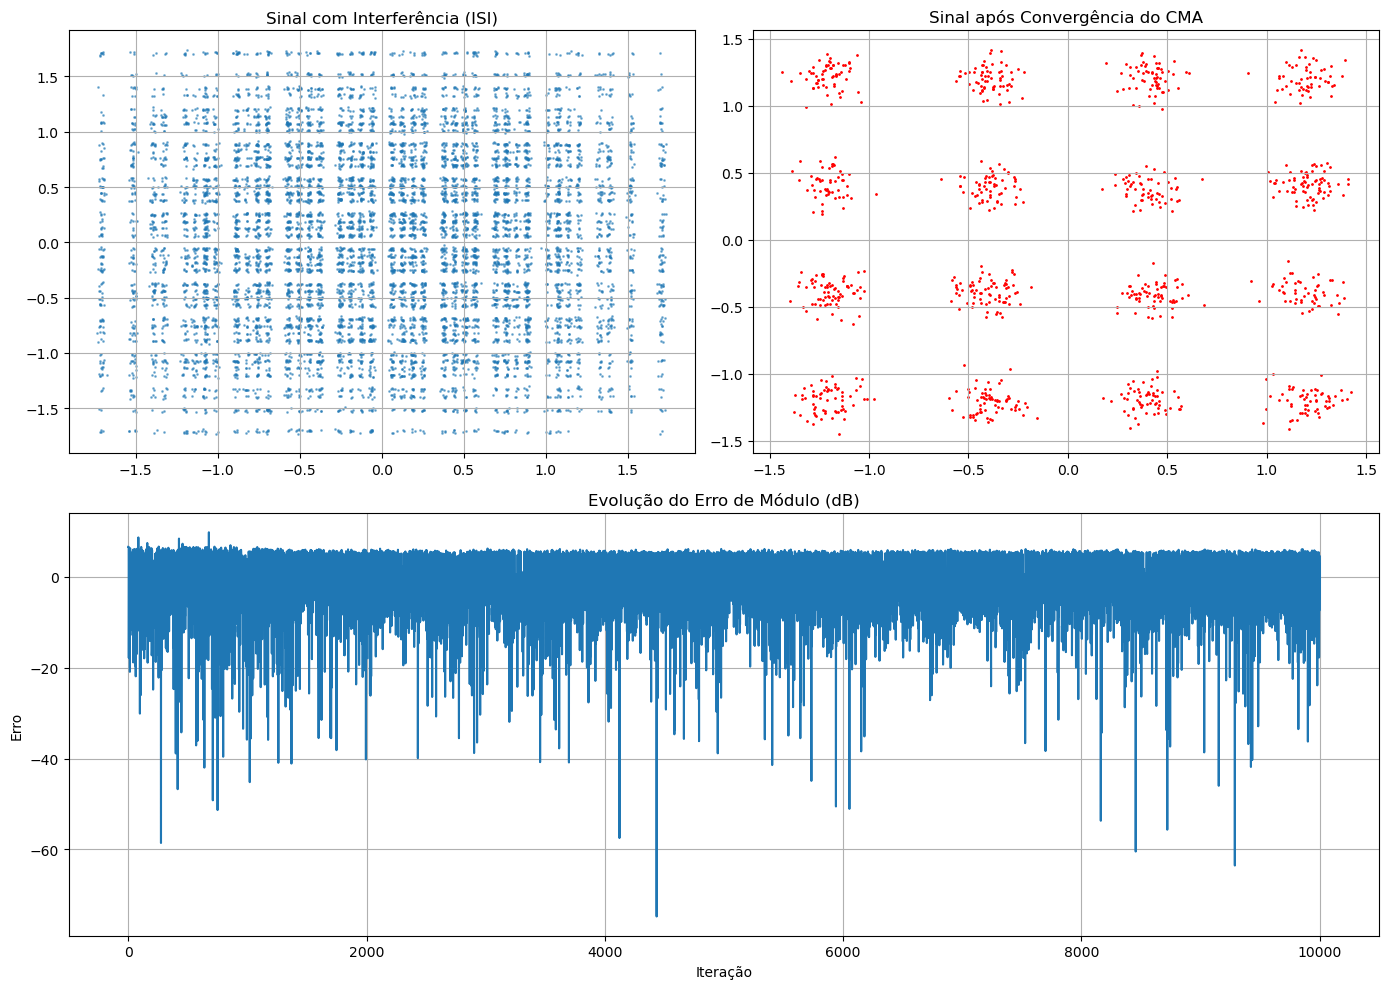

In [4]:
plt.figure(figsize=(14, 10))

# Plot da Constelação Original vs Distorcida vs Equalizada
plt.subplot(2, 2, 1)
plt.scatter(x_distorted.real, x_distorted.imag, s=1, alpha=0.5, label='Distorcida (Entrada)')
plt.title("Sinal com Interferência (ISI)")
plt.grid(True)

plt.subplot(2, 2, 2)
# Pegamos apenas as últimas 1000 amostras para garantir que o filtro convergiu
plt.scatter(y[-1000:].real, y[-1000:].imag, s=1, color='red', label='Equalizada (Saída)')
plt.title("Sinal após Convergência do CMA")
plt.grid(True)

# Evolução do Erro de Módulo (CMA Error)
plt.subplot(2, 1, 2)
plt.plot(10 * np.log10(np.abs(e)**2 + 1e-12))
plt.title("Evolução do Erro de Módulo (dB)")
plt.xlabel("Iteração")
plt.ylabel("Erro")
plt.grid(True)

plt.tight_layout()
plt.show()